In [1]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


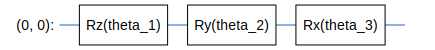

In [2]:
# Parameters that the classical NN will feed values into.
control_params = sympy.symbols('theta_1 theta_2 theta_3')

# Create the parameterized circuit.
qubit = cirq.GridQubit(0, 0)
model_circuit = cirq.Circuit(
    cirq.rz(control_params[0])(qubit),
    cirq.ry(control_params[1])(qubit),
    cirq.rx(control_params[2])(qubit))

SVGCircuit(model_circuit)

In [3]:
# The classical neural network layers.
controller = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='elu'),
    tf.keras.layers.Dense(3)
])

# Commands will be either `0` or `1`, specifying the state to set the qubit to.
commands_input = tf.keras.Input(shape=(1,),
                                dtype=tf.dtypes.float32,
                                name='commands_input')

dense_2 = controller(commands_input)

controller(tf.constant([[0.0],[1.0]])).numpy()

array([[ 0.       ,  0.       ,  0.       ],
       [-0.3595314,  1.2782818, -0.5398004]], dtype=float32)

In [4]:
# This input is the simulated miscalibration that the model will learn to correct.
circuits_input = tf.keras.Input(shape=(),
                                # The circuit-tensor has dtype `tf.string` 
                                dtype=tf.string,
                                name='circuits_input')

In [5]:
# TFQ layer for classically controlled circuits.
expectation_layer = tfq.layers.ControlledPQC(model_circuit,
                                             # Observe Z
                                             operators = cirq.Z(qubit))
expectation = expectation_layer([circuits_input, dense_2])

In [6]:
# The full Keras model is built from our layers.
model = tf.keras.Model(inputs=[circuits_input, commands_input],
                       outputs=expectation)

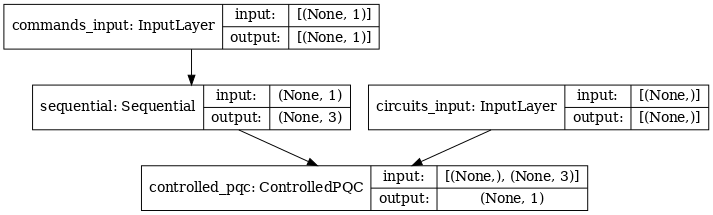

In [7]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=70)

In [8]:
# The command input values to the classical NN.
commands = np.array([[0], [1]], dtype=np.float32)

# The desired Z expectation value at output of quantum circuit.
expected_outputs = np.array([[1], [-1]], dtype=np.float32)

In [9]:
random_rotations = np.random.uniform(0, 2 * np.pi, 3)
noisy_preparation = cirq.Circuit(
  cirq.rx(random_rotations[0])(qubit),
  cirq.ry(random_rotations[1])(qubit),
  cirq.rz(random_rotations[2])(qubit)
)
datapoint_circuits = tfq.convert_to_tensor([
  noisy_preparation
] * 2)  # Make two copied of this circuit

In [10]:
datapoint_circuits.shape

TensorShape([2])

In [11]:
model([datapoint_circuits, commands]).numpy()

array([[ 0.8949059 ],
       [-0.05484655]], dtype=float32)

In [13]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)
loss = tf.keras.losses.MeanSquaredError()
model.compile(optimizer=optimizer, loss=loss)
history = model.fit(x=[datapoint_circuits, commands],
                    y=expected_outputs,
                    epochs=30,
                    verbose=0)

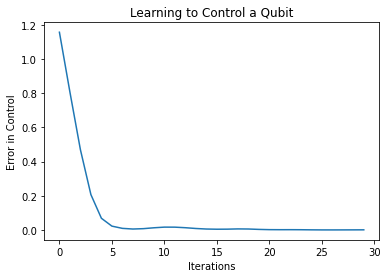

In [14]:
plt.plot(history.history['loss'])
plt.title("Learning to Control a Qubit")
plt.xlabel("Iterations")
plt.ylabel("Error in Control")
plt.show()

In [16]:
cirq_simulator = cirq.Simulator()

def check_error(command_values, desired_values):
  """Based on the value in `command_value` see how well you could prepare
  the full circuit to have `desired_value` when taking expectation w.r.t. Z."""
  params_to_prepare_output = controller(command_values).numpy()
  full_circuit = noisy_preparation + model_circuit

  # Test how well you can prepare a state to get expectation the expectation
  # value in `desired_values`
  for index in [0, 1]:
    state = cirq_simulator.simulate(
        full_circuit,
        {s:v for (s,v) in zip(control_params, params_to_prepare_output[index])}
    ).final_state_vector
    expt = cirq.Z(qubit).expectation_from_state_vector(state, {qubit: 0}).real
    print(f'For a desired output (expectation) of {desired_values[index]} with'
          f' noisy preparation, the controller\nnetwork found the following '
          f'values for theta: {params_to_prepare_output[index]}\nWhich gives an'
          f' actual expectation of: {expt}\n')


check_error(commands, expected_outputs)

For a desired output (expectation) of [1.] with noisy preparation, the controller
network found the following values for theta: [ 3.6673176   0.32070616 -4.4520264 ]
Which gives an actual expectation of: 0.9589784741401672

For a desired output (expectation) of [-1.] with noisy preparation, the controller
network found the following values for theta: [-0.19239134 -0.91532063  0.47329903]
Which gives an actual expectation of: -0.9901111721992493



In [17]:
model([datapoint_circuits, commands])

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[ 0.9589784],
       [-0.9901112]], dtype=float32)>